## Homework 06: due 2022/06/05 23:59(110%)

### - There are differences between every OpenCV version, please use the version 4.4.0.40 to avoid generating bugs.  

### - Tutorial : 
1. Panorama tutorial : https://datahacker.rs/005-how-to-create-a-panorama-image-using-opencv-with-python/
2. cv2.Sticher document: https://docs.opencv.org/4.4.0/d2/d8d/classcv_1_1Stitcher.html
3. cv2.Sticher tutorial: https://docs.opencv.org/4.4.0/d5/d48/samples_2python_2stitching_8py-example.html

                   
### - After you go through the tutorials, you should be able to work on this assignment.

### - Please answer the following questions and work directly on this jupyter notebook.

### - Make sure the code can be run and show the result and figures properly.

### - Please write down your observation with markdown in this notebook briefly.

In [ ]:
# Set up the environment
## Install opencv with version 4.4.0
!pip3 install opencv-python==4.4.0.40

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49.4 MB 1.7 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
# Download the Data
!gdown --id "1ZFKekBs_LWkzNbfHUfftdbxEVI2SeXiZ" --output data.zip
!unzip data.zip 

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1ZFKekBs_LWkzNbfHUfftdbxEVI2SeXiZ
To: /content/data.zip
100% 3.44M/3.44M [00:00<00:00, 232MB/s]
Archive:  data.zip
  inflating: Data/01.jpg             
  inflating: Data/02.jpg             
  inflating: Data/03.jpg             
  inflating: Data/04.jpg             
  inflating: Data/05.jpg             
  inflating: Data/06.jpg             
  inflating: Data/07.jpg             


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

### 1. Feature Matching (50%)
#### Please use __SIFT__ as detector and descriptor to find the correponding feature points in __./Data/01.jpg__ and __./Data/02.jpg__. Also, please apply Lowe's ratio test with appropriate ratio and draw the matching feature points as the figure below.
##### (example figure)
![figure1.jpg](https://github.com/tingyan08/Deep-Learning-and-Computer-Vision/blob/main/HW6/fig/figure1.jpg?raw=true)

In [ ]:
# read image
img1 = cv2.imread('./Data/01.jpg', cv2.COLOR_BGR2GRAY) # queryImage
img2 = cv2.imread('./Data/02.jpg', cv2.COLOR_BGR2GRAY) # trainImage

# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)

In [ ]:
# Lowe's ratio
ratio_six = []
for a,b in matches:
    if a.distance < 0.6*b.distance:
        ratio_six.append([a])


img_six = cv2.drawMatchesKnn(img1,kp1,img2,kp2,ratio_six,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
img_six = cv2.cvtColor(img_six, cv2.COLOR_BGR2RGB)

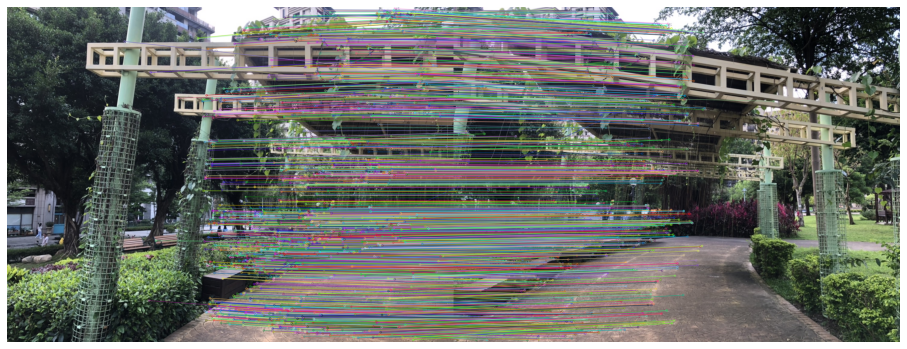

In [ ]:
# show image
plt.figure(figsize=(16,8))
plt.axis('off')
plt.imshow(img_six)
plt.show()

# Observations
> This question is identical as HW5，using the ratio 0.6 to construct the feature matching. As we create the point correspondences from SIFT algorithm, some matches are not correct, which mean inside the correspondences there have some outliers are mismatched. The outliers will have impacts on homography matrix, causing the transformation from two images not accurate. 

### 2. Homography and stitching. (50%)
#### Please calculate the homography matrix with the point correspondences that detect from the first part. Also, warp the images and stitch them together. (cv2.Sticher is not allowed in this part)
##### (Example figure)
![figure2.jpg](https://github.com/tingyan08/Deep-Learning-and-Computer-Vision/blob/main/HW6/fig/figure2.jpg?raw=true)

In [ ]:
def draw_matches(img1, keypoints1, img2, keypoints2, matches):
  r, c = img1.shape[:2]
  r1, c1 = img2.shape[:2]

  # Create a blank image with the size of the first image + second image
  output_img = np.zeros((max([r, r1]), c+c1, 3), dtype='uint8')
  output_img[:r, :c, :] = np.dstack([img1, img1, img1])
  output_img[:r1, c:c+c1, :] = np.dstack([img2, img2, img2])

  # Go over all of the matching points and extract them
  for match in matches:
    img1_idx = match.queryIdx
    img2_idx = match.trainIdx
    (x1, y1) = keypoints1[img1_idx].pt
    (x2, y2) = keypoints2[img2_idx].pt

    # Draw circles on the keypoints
    cv2.circle(output_img, (int(x1),int(y1)), 4, (0, 255, 255), 1)
    cv2.circle(output_img, (int(x2)+c,int(y2)), 4, (0, 255, 255), 1)

    # Connect the same keypoints
    cv2.line(output_img, (int(x1),int(y1)), (int(x2)+c,int(y2)), (0, 255, 255), 1)
    
  return output_img

In [ ]:
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
all_matches = []
for m, n in matches:
  all_matches.append(m)

In [ ]:
# Finding the best matches
good = []
for m, n in matches:
    if m.distance < 0.6 * n.distance:
        good.append(m)

In [ ]:
def warpImages(img1, img2, H):

  rows1, cols1 = img1.shape[:2]
  rows2, cols2 = img2.shape[:2]

  list_of_points_1 = np.float32([[0,0], [0, rows1],[cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
  temp_points = np.float32([[0,0], [0,rows2], [cols2,rows2], [cols2,0]]).reshape(-1,1,2)

  # When we have established a homography we need to warp perspective
  # Change field of view
  list_of_points_2 = cv2.perspectiveTransform(temp_points, H)

  list_of_points = np.concatenate((list_of_points_1,list_of_points_2), axis=0)

  [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
  [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)
  
  translation_dist = [-x_min,-y_min]
  
  H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

  output_img = cv2.warpPerspective(img2, H_translation.dot(H), (x_max-x_min, y_max-y_min))
  output_img[translation_dist[1]:rows1+translation_dist[1], translation_dist[0]:cols1+translation_dist[0]] = img1

  return output_img

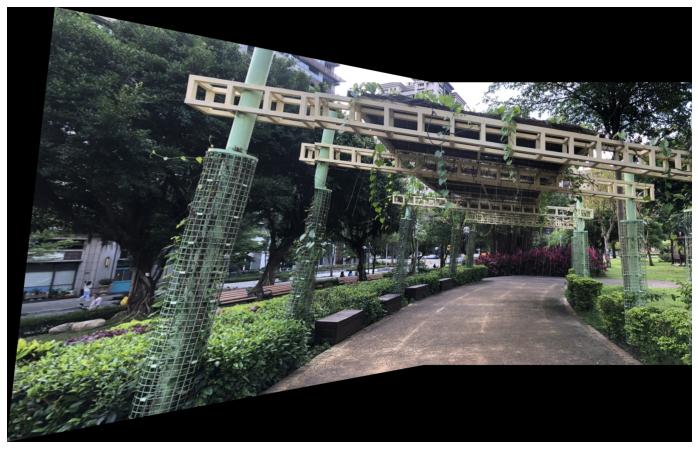

In [ ]:
# Set minimum match condition
MIN_MATCH_COUNT = 10

if len(good) > MIN_MATCH_COUNT:
    # Convert keypoints to an argument for findHomography
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)

    # Establish a homography
    M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    
    result = warpImages(img2, img1, M)
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
# show image
plt.figure(figsize=(16,8))
plt.imshow(result)
plt.axis('off')
plt.show()

### 3. (Bonus) Warping transformation (10%)
#### Please read the tutorials and the documentations of __cv2.Stitcher__, and  compare the differences between the panorama below and the panorama from the last question. Write down your observation. 
##### ___(No need to implement for this part!)___

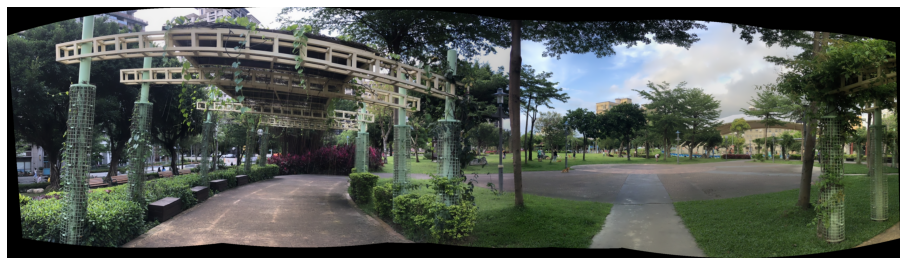

In [ ]:
path = "./Data"
img_list = [cv2.imread(i) for i in sorted(glob.glob(os.path.join(path, "*.jpg")))]
sticher = cv2.Stitcher_create(cv2.Stitcher_PANORAMA)
ret, pano = sticher.stitch(img_list)
plt.figure(figsize=(16,8))
plt.imshow(pano[:,:,::-1])
plt.axis("off")
plt.show()

# Observations
> From the panorama below you can see there's only one image change its size and angle to the right and the image on the right still remains the original angle but scale down its image, comparing with the cv2.Stitcher_PANORAMA, i think every image will change its angle and size simuitaneouslly.